In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np
import joblib

In [6]:
train = pd.read_csv('s3://german-credit-80195/datos/train/train.csv')
test = pd.read_csv('s3://german-credit-80195/datos/test/test.csv')
features = ["Age","Credit amount","Duration","Sex","Purpose","Housing"]

In [ ]:
#Creacion de Pipeline sin la explicacion del otro codigo, 'modo rapido'

In [7]:
numeric_pipeline = Pipeline(
    [
        ('Imputación con la media',   SimpleImputer(strategy='mean')),
        ('Escalado minmax', MinMaxScaler())
        
    ]
)

In [8]:
categorical_pipeline = Pipeline(
        [
            ('imputación moda', SimpleImputer(strategy='most_frequent')),
            ('onehot encoder', OneHotEncoder(sparse=False))
        ]

)

In [9]:
column_transformer = ColumnTransformer(
            [
                ('numeric pipeline', numeric_pipeline, [0, 1, 2]),
                ('categorical pipeline', categorical_pipeline, [3, 4, 5])
            ]
)
#se ponen los indices de las columnas

In [ ]:
###  Seleccion de caracteristicas iniciemos con arboles

In [10]:
train = train.dropna()
X_train = train.drop(["Risk","Unnamed: 0"], axis =1) #quitamos la dependiente para armar x pero tambien vars inutiles
y_train = train["Risk"] #recordar que risk es lo que queremis predecir
y_train = (y_train=='good').astype("int")
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361 entries, 0 to 699
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               361 non-null    int64 
 1   Sex               361 non-null    object
 2   Job               361 non-null    int64 
 3   Housing           361 non-null    object
 4   Saving accounts   361 non-null    object
 5   Checking account  361 non-null    object
 6   Credit amount     361 non-null    int64 
 7   Duration          361 non-null    int64 
 8   Purpose           361 non-null    object
dtypes: int64(4), object(5)
memory usage: 28.2+ KB


In [11]:
X_train = pd.get_dummies(X_train) #hace lo mismo que one hot pero mas rapido


In [12]:
model = DecisionTreeClassifier()


In [13]:
model.fit(X_train,y_train)

DecisionTreeClassifier()

In [14]:
model.feature_importances_

array([0.11221695, 0.04757882, 0.33801384, 0.1870724 , 0.02247691,
       0.        , 0.02620219, 0.02809951, 0.02959031, 0.01211881,
       0.02809951, 0.01864187, 0.        , 0.02505021, 0.0149864 ,
       0.01648504, 0.        , 0.05614269, 0.        , 0.00760165,
       0.00956721, 0.01177909, 0.00827658, 0.        ])

In [ ]:
#El feature con mayor diversidad o variabza es el mas importante

In [15]:
X_train.columns

Index(['Age', 'Job', 'Credit amount', 'Duration', 'Sex_female', 'Sex_male',
       'Housing_free', 'Housing_own', 'Housing_rent', 'Saving accounts_little',
       'Saving accounts_moderate', 'Saving accounts_quite rich',
       'Saving accounts_rich', 'Checking account_little',
       'Checking account_moderate', 'Checking account_rich',
       'Purpose_business', 'Purpose_car', 'Purpose_domestic appliances',
       'Purpose_education', 'Purpose_furniture/equipment', 'Purpose_radio/TV',
       'Purpose_repairs', 'Purpose_vacation/others'],
      dtype='object')

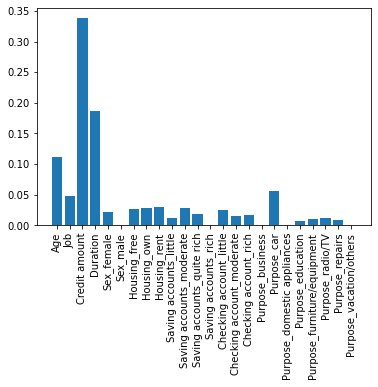

In [16]:
plt.bar(x=X_train.columns, height=model.feature_importances_)
plt.xticks(rotation = 90)
plt.show()

In [17]:
order_columns=X_train.columns[np.argsort(model.feature_importances_)[::-1]]#regresa posicion y no valores ordenado  con lo que esta en[le damos la vuelta]

In [18]:
ordered_importance = np.sort(model.feature_importances_)[::-1]

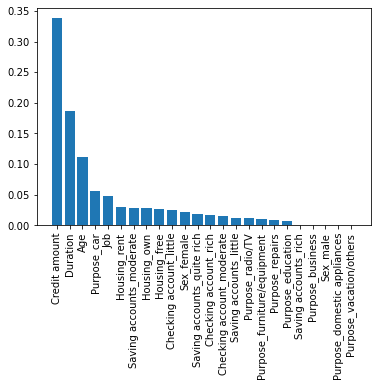

In [19]:
plt.bar(x=order_columns,
       height=ordered_importance)
plt.xticks(rotation = 90)
plt.show()

In [ ]:
#ahora miramos las caracteristicas con regresion logistica

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler  #los datos tienen que ir escalados, para la logistica no importa y escalado
X_train_scaled = MinMaxScaler().fit_transform(X_train)

In [21]:
model = LogisticRegression()

In [22]:
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [23]:
model.coef_

array([[ 0.47424606,  0.46040332, -0.92624159, -2.03116232, -0.19687034,
         0.19696162,  0.06881668,  0.14613817, -0.21486357, -0.46689979,
        -0.41031105,  0.29891103,  0.57839108, -0.38283643, -0.16388134,
         0.54680905,  0.28173634,  0.11494351, -0.14531633, -0.93147024,
         0.17853055,  0.27162217,  0.07962265,  0.15042262]])

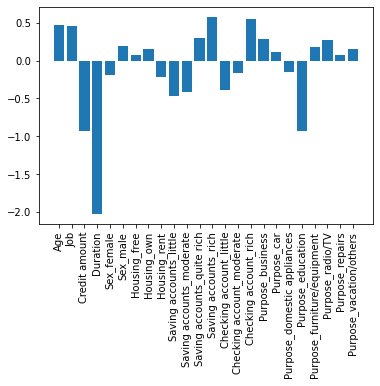

In [24]:
plt.bar(x=X_train.columns,
       height=model.coef_[0])
plt.xticks(rotation = 90)
plt.show()

In [68]:
##################Evaluacion de modelos###################################################################
#cargamos la info de nuevo para meyor 
train = pd.read_csv('s3://german-credit-80195/datos/train/train.csv')
X_train = train.drop(["Risk","Unnamed: 0"], axis =1) #quitamos la dependiente para armar x pero tambien vars inutiles
y_train = train["Risk"] #recordar que risk es lo que queremis predecir
y_train = (y_train=='good').astype("int")

In [73]:
#primero arboles
final_pipeline = Pipeline(
    [
       ("preprocesamiento", column_transformer), 
       ("modelo",DecisionTreeClassifier(max_depth=3))
    ]
)

In [74]:
X_train = train[features]

In [75]:
results = cross_validate(final_pipeline, X_train, y_train, cv=10, scoring=["accuracy","f1"])


In [77]:
#print(results)
for key, value in results.items() :
    print (key)

fit_time
score_time
test_accuracy
test_f1


In [60]:
#ahora random forrest
final_pipeline2 = Pipeline(
    [
       ("preprocesamiento", column_transformer), 
       ("modelo",RandomForestClassifier)
    ]
)

In [79]:
results2 = cross_validate(final_pipeline2, X_train, y_train, cv=10, scoring=["accuracy","f1"])

/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
TypeError: fit() missing 1 required positional argument: 'y'

  warnings.warn(

In [85]:
#print(results2)
#for key, value in results2.items() :
#    print (key)
print(results2['test_f1'])

[nan nan nan nan nan nan nan nan nan nan]


In [86]:
#Ajuste de hiperparamentros probar 50 arboles, 100 arboles, 200 arboles, alturas 2,3,4,5,10

In [89]:
train = pd.read_csv('s3://german-credit-80195/datos/train/train.csv')
X_train = train.drop(["Risk","Unnamed: 0"], axis =1) #quitamos la dependiente para armar x pero tambien vars inutiles
y_train = train["Risk"] #recordar que risk es lo que queremis predecir
y_train = (y_train=='good').astype("int")

In [101]:
from sklearn.model_selection import GridSearchCV

In [102]:
grid = {'n_estimators':[2,3,5,10], "max_depth": [50,100,200]}  #diccinorio con hiperparametros 


In [153]:
X_transformed = column_transformer.fit_transform(X_train)
#grid_search = GridSearchCV(
#RandomForestClassifier(),
#param_grid=grid,
#cv=10,
#scoring="accuracy"
#)

ValueError: Cannot use mean strategy with non-numeric data:
could not convert string to float: 'male'

In [99]:
grid_search.fit(X_transformed,y_train)

NameError: name 'X_transformed' is not defined